In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = 'F:/Books/Machine Learning/DataSets/Titanic'
raw_data = pd.read_csv('all_data.csv')
train_label = pd.read_csv('labels.csv')
sub_data = pd.read_csv(path + '/gender_submission.csv')

# One Hot Encoding
raw_data = pd.concat([raw_data , pd.get_dummies(raw_data.Sex,drop_first=True,prefix='Sex'),
pd.get_dummies(raw_data.Pclass,drop_first=True,prefix='Pclass'),
pd.get_dummies(raw_data.Embarked,drop_first=True,prefix='Embarked')],axis=1)
raw_data.drop(['Pclass','Embarked','Sex'],axis=1,inplace=True)
raw_data.head()

# Seperating data
train_data = raw_data.iloc[:891]
test_data = raw_data.iloc[891:]

## Normalize
sc_age = StandardScaler()
train_data.Age = sc_age.fit_transform(train_data.Age.values.reshape(-1,1))

sc_fare = StandardScaler()
train_data.Fare = sc_fare.fit_transform(train_data.Fare.values.reshape(-1,1))

# Remove outliers
drop_obser = []
drop_obser.extend(train_data.SibSp[train_data.SibSp > 5].index.tolist())
drop_obser.extend(train_data.Parch[train_data.Parch > 4].index.tolist())
train_data.drop(set(drop_obser),inplace=True)
train_label.drop(set(drop_obser),inplace=True)

In [3]:
from xgboost              import XGBClassifier
from sklearn.svm          import SVC
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import ExtraTreesClassifier 
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.metrics      import r2_score, accuracy_score, mean_squared_error
from sklearn.pipeline     import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix 

In [5]:
x_train, x_test, y_train, y_test = train_test_split(train_data,
                                                    train_label,
                                                   test_size=.30,
                                                   random_state= 42,
                                                   shuffle=True)

In [44]:
pipelines = []
n_estimators = 200
seed = 42
pipelines.append( ( 'SVC' , Pipeline( [('SVC',SVC()) ]) ) ) 

pipelines.append( ( 'KNN' , Pipeline( [('KNN',KNeighborsClassifier()) ]) ) )

pipelines.append( ( 'RF'  , Pipeline( [('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ) )

pipelines.append( ( 'Ada' , Pipeline( [('Ada',AdaBoostClassifier(random_state=seed    , n_estimators=n_estimators)) ]) ) )

pipelines.append( ( 'ET'  , Pipeline( [('ET', ExtraTreesClassifier(random_state=seed  , n_estimators=n_estimators)) ]) ) )

pipelines.append( ( 'GB'  , Pipeline( [('GB', GradientBoostingClassifier(random_state=seed)) ]) ) )

pipelines.append( ( 'XGB'  , Pipeline( [('XGB', XGBClassifier(random_state=seed)) ]) ) )


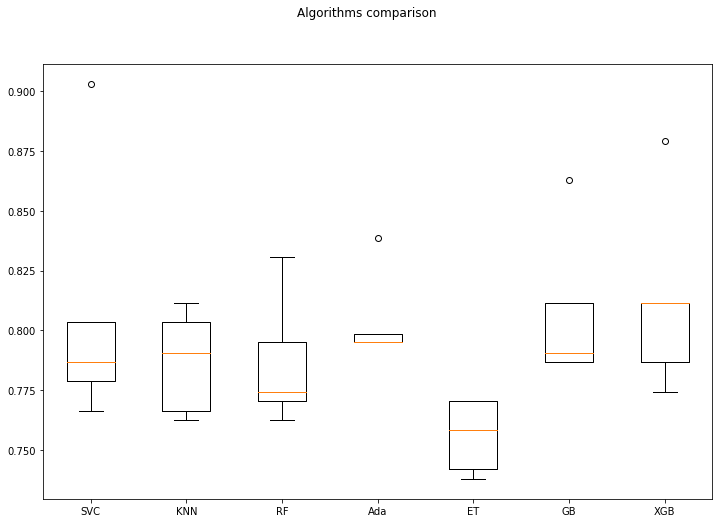

In [45]:
results, names  = [], []
for name, model in pipelines:
    cv_results = cross_val_score(model, x_train, y_train, cv = 5 ) 
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure(figsize=(12,8))    
fig.suptitle("Algorithms comparison")
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [46]:
score = pd.DataFrame(results,index=names,columns=['CV1','CV2','CV3','CV4','CV5'])
score

,CV1,CV2,CV3,CV4,CV5
SVC,0.903226,0.766129,0.786885,0.778689,0.803279
KNN,0.790323,0.766129,0.762295,0.811475,0.803279
RF,0.830645,0.774194,0.762295,0.795082,0.770492
Ada,0.838710,0.798387,0.795082,0.795082,0.795082
ET,0.741935,0.758065,0.737705,0.770492,0.770492
GB,0.862903,0.790323,0.811475,0.786885,0.786885
XGB,0.879032,0.774194,0.811475,0.786885,0.811475


# SVC Hypertuning 

In [6]:
svc = SVC()
svc.fit(x_train,y_train)
svc.score(x_test,y_test)

0.8371212121212122

In [8]:
  # defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,5,10], 
              'kernel': ['linear', 'rbf']}
svc = SVC()
grid_ = RandomizedSearchCV ( estimator=svc , param_distributions=param_grid,cv = 5,verbose = 10,n_jobs=-1)
grid_model = grid_.fit(x_train,y_train) 
  
print("Best: %f using %s" % (grid_model.best_score_, grid_model.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.3s remaining:    0.9s


Best: 0.789902 using {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
0.8068181818181818


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.0s finished
C:\Users\GirrajJangid\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NameError: name 'grid_predictions' is not defined

In [12]:
param = {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
svc = SVC(**param)
svc.fit(x_train,y_train)
svc.score(x_test,y_test)

# Dont getting a good pridiction over hypertuning

0.8068181818181818

# XGB Tuning 

In [67]:
params = {'learning_rate':[0.1,0.08,0.05,0.01,0.001],
         'gamma':[0.01,0.1,0.3,0.5,1,1.5,2],
         'max_depth':[2,4,7,10],
         'colsample_bytree':[0.3,0.6,0.8,1],
         "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
         "reg_alpha": [0, 0.5, 1],
         "reg_lambda": [1, 1.5, 2, 3, 4.5],
         "min_child_weight": [1, 3, 5, 7],
         "n_estimators": [100, 250, 500, 1000]}

xgb_clf = XGBClassifier()

xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = params,
                             cv = 7, verbose = 3, random_state = 40, n_jobs=-1)

model_xgb = xgb_rscv.fit(x_train,y_train)

print("Best: %f using %s" % (model_xgb.best_score_, model_xgb.best_params_))

print(model_xgb.score(x_test,y_test))

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.8s finished


Best: 0.806189 using {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1.5, 'colsample_bytree': 0.8}
0.8409090909090909


In [69]:
best_params = {'subsample': [0.6,0.65,0.55], 
               'reg_lambda': [1,1.2,0.8] ,
               'reg_alpha': [0,0.1,0.09] ,
               'n_estimators': [500,450,480,520], 
               'min_child_weight': [1,2,3], 
               'max_depth': [7,5,6] ,
               'learning_rate': [0.01,0.02,0.03] ,
               'gamma': [1.5,1.2,1.7], 
               'colsample_bytree': [0.8,0.9,0.85]}

xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = best_params,
                             cv = 10, verbose = 3, random_state = 40, n_jobs=-1)

model_xgb = xgb_rscv.fit(x_train,y_train)

print("Best: %f using %s" % (model_xgb.best_score_, model_xgb.best_params_))

print(model_xgb.score(x_test,y_test))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished


Best: 0.817590 using {'subsample': 0.55, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 520, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 1.2, 'colsample_bytree': 0.9}
0.8409090909090909


In [70]:
best_params_1 = {'subsample': 0.6, 
                 'reg_lambda': 1,
                 'reg_alpha': 0, 
                 'n_estimators': 500, 
                 'min_child_weight': 3, 
                 'max_depth': 7,
                 'learning_rate': 0.01, 
                 'gamma': 1.5, 
                 'colsample_bytree': 0.8}

best_params_2 ={ 'subsample': 0.55, 
                'reg_lambda': 1, 
                'reg_alpha': 0, 
                'n_estimators': 520,
                'min_child_weight': 3,
                'max_depth': 6,
                'learning_rate': 0.03,
                'gamma': 1.2,
                'colsample_bytree': 0.9}

xgb_1 = XGBClassifier(**best_params_1)
xgb_1.fit(x_train,y_train)

xgb_2 = XGBClassifier(**best_params_2)
xgb_2.fit(x_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=1.2,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, n_estimators=520, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.55, verbosity=1)

# AdaBoost Tuning

In [13]:
adcl = AdaBoostClassifier()
adcl.fit(x_train,y_train)
adcl.score(x_test,y_test)

0.803030303030303

In [16]:
param = { 'n_estimators': [50,100,200,500,1000], 
         'learning_rate': [1.0,0.01,0.1,0.5,0.05]  }

adcl = AdaBoostClassifier()
adb_rscv = RandomizedSearchCV(adcl, param_distributions = param,
                             cv = 5, verbose = 10, random_state = 40, n_jobs=-1)

model_adb = adb_rscv.fit(x_train,y_train)

print("Best: %f using %s" % (model_adb.best_score_, model_adb.best_params_))

print(model_adb.score(x_test,y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    6.9s remaining:    1.4s


Best: 0.804560 using {'n_estimators': 50, 'learning_rate': 0.5}
0.7992424242424242


[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    7.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.1s finished
C:\Users\GirrajJangid\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
# doesnt provide good solution

# Stacking method

In [32]:
df = pd.DataFrame()
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
df = pd.concat([df , pd.DataFrame(y_pred_svc,columns=['SVC'])],axis=1)

adb = AdaBoostClassifier()
adb.fit(x_train,y_train)
y_pred_adb = adb.predict(x_test)
df = pd.concat([df , pd.DataFrame(y_pred_adb,columns=['ADB'])],axis=1)

best_params_1 = {'subsample': 0.6, 
                 'reg_lambda': 1,
                 'reg_alpha': 0, 
                 'n_estimators': 500, 
                 'min_child_weight': 3, 
                 'max_depth': 7,
                 'learning_rate': 0.01, 
                 'gamma': 1.5, 
                 'colsample_bytree': 0.8}
xgb_1 = XGBClassifier(**best_params_1)
xgb_1.fit(x_train,y_train)
y_pred_xgb1 = xgb_1.predict(x_test)
df = pd.concat([df , pd.DataFrame(y_pred_xgb1,columns=['XGB_1'])],axis=1)


best_params_2 ={ 'subsample': 0.55, 
                'reg_lambda': 1, 
                'reg_alpha': 0, 
                'n_estimators': 520,
                'min_child_weight': 3,
                'max_depth': 6,
                'learning_rate': 0.03,
                'gamma': 1.2,
                'colsample_bytree': 0.9}


xgb_2 = XGBClassifier(**best_params_2)
xgb_2.fit(x_train,y_train)
y_pred_xgb2 = xgb_2.predict(x_test)
df = pd.concat([df , pd.DataFrame(y_pred_xgb2,columns=['XGB_2'])],axis=1)

gdb = GradientBoostingClassifier()
gdb.fit(x_train,y_train)
y_pred_gdb = gdb.predict(x_test)
df = pd.concat([df , pd.DataFrame(y_pred_adb,columns=['GRB'])],axis=1)


In [41]:
y_pred = xgb_2.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       165
           1       0.81      0.76      0.78        99

    accuracy                           0.84       264
   macro avg       0.83      0.82      0.83       264
weighted avg       0.84      0.84      0.84       264



In [48]:
print(classification_report(y_test,df.mode(axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       165
           1       0.76      0.79      0.77        99

    accuracy                           0.83       264
   macro avg       0.81      0.82      0.82       264
weighted avg       0.83      0.83      0.83       264



In [50]:
accuracy_score(y_test,y_pred_xgb2)

0.8409090909090909

In [57]:
best_params_2 ={ 'subsample': 0.55, 
                'reg_lambda': 1, 
                'reg_alpha': 0, 
                'n_estimators': 520,
                'min_child_weight': 3,
                'max_depth': 6,
                'learning_rate': 0.03,
                'gamma': 1.2,
                'colsample_bytree': 0.9}


xgb_2 = XGBClassifier(**best_params_2)
xgb_2.fit(train_data,train_label)
y_pred_xgb2 = xgb_2.predict(test_data)


In [64]:
sub_data.Survived = y_pred_xgb2

In [68]:
sub_data.Survived = y_pred_xgb2
sub_data.to_csv('submission2.csv',index=False)

In [69]:
pd.read_csv('submission2.csv')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
